In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import math
import statsmodels.api as sm
import seaborn as sns
import pingouin as pg
from matplotlib.colors import ListedColormap
pd.options.mode.chained_assignment = None

In [2]:
measurements = pd.read_excel(r'Z:\grodriguez\CardiacOCT\code\count-distributions\manual_vs_automatic_measures.xlsx', sheet_name='Lipid new test set')

## Functions

In [27]:
def get_data_filtered(test_sheet, type_manual, type_ai, missing = -99):

    manual = test_sheet[type_manual]
    ai = test_sheet[type_ai]

    list_fp = []
    list_fn = []
    list_nulls = []
    list_drops = []
    fp_count = 0
    fn_count = 0

    for value in range(len(manual)):

        if manual[value] == missing and ai[value] != missing:
            list_fp.append(value)
            fp_count += 1

        if manual[value] != missing and ai[value] == missing:
            list_fn.append(value)
            fn_count += 1

        if manual[value] == missing and ai[value] == missing:
            list_nulls.append(value)

        if math.isnan(ai[value]):
            list_nulls.append(value)

    list_drops.extend(list_fp)
    list_drops.extend(list_fn)
    list_drops.extend(list_nulls)

    ai.drop(list_drops, inplace=True)
    manual.drop(list_drops, inplace=True)

    print('Found {} FP and {} FN. Total values are {}'.format(fp_count, fn_count, len(manual)))

    return manual, ai

In [28]:
def corr_plot(manual, automatic, thresh, title):

    print('Corr {}: {}'.format(title, np.corrcoef(manual, automatic)))

    col = []
    for i, j in zip(manual, automatic):
        if i <= thresh and j >= thresh:
            col.append(0)

        elif i >= thresh and j <= thresh:
            col.append(1)

        else:
            col.append(2)

    classes = ['FP', 'FN', 'TP/TN']
    scatter = plt.scatter(manual, automatic, c=col, cmap=ListedColormap(['black', 'green', 'blue']))
    plt.axhline(thresh, color='r')
    plt.axvline(thresh, color='r')
    plt.xlabel('Manual')
    plt.ylabel('Automatic')
    plt.title(title)
    plt.legend(handles=scatter.legend_elements()[0], labels = classes)
    plt.show()

In [29]:
def calculate_icc(automatic_values, manual_values):

    raters1 = ['Automatic' for _ in range(len(automatic_values))]
    raters2 = ['Manual' for _ in range(len(automatic_values))]
    raters1.extend(raters2)

    exam1 = list(np.arange(0, len(automatic_values)))
    exam2 = list(np.arange(0, len(automatic_values)))
    exam1.extend(exam2)

    values_fct = pd.concat([automatic_values, manual_values])

    icc_df = pd.DataFrame({'exam': exam1, 'raters': raters1, 'fct': values_fct})

    icc = pg.intraclass_corr(icc_df, 'exam', 'raters', 'fct')

    return icc

# Bland Altman manual vs automatic

Found 9 FP and 3 FN. Total values are 73
95.63604226556758


(-400.0, 400.0)

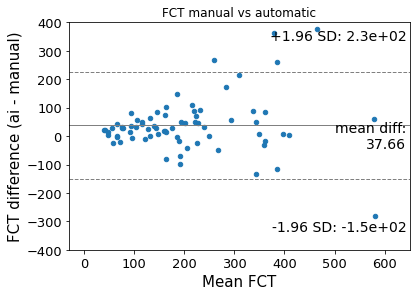

In [41]:
manual_fct, ai_fct_model3 = get_data_filtered(measurements, 'FCT automatic', 'FCT model 3 2D')
mean = np.mean([manual_fct, ai_fct_model3], axis=0)
diff = manual_fct - ai_fct_model3                   
md = np.mean(diff)                   
sd = np.std(diff, axis=0) 
print(sd)

fig, axes = plt.subplots()

sm.graphics.mean_diff_plot(ai_fct_model3, manual_fct, ax = axes)
plt.xlabel('Mean FCT')
plt.ylabel('FCT difference (ai - manual)')
plt.title('FCT manual vs automatic')
plt.xlim(-30, 650)
plt.ylim(-400, 400)

Found 9 FP and 3 FN. Total values are 73
22.046514228820477


(-75.0, 150.0)

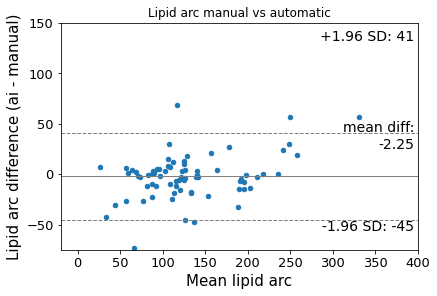

In [42]:
manual_arc, ai_arc_model3 = get_data_filtered(measurements, 'Lipid arc manual', 'Lipid arc model 3 2D')
mean = np.mean([manual_arc, ai_arc_model3], axis=0)
diff = manual_arc - ai_arc_model3                   
md = np.mean(diff)                   
sd = np.std(diff, axis=0) 
print(sd)

fig, axes = plt.subplots()

sm.graphics.mean_diff_plot(ai_arc_model3, manual_arc, ax = axes)
plt.xlabel('Mean lipid arc')
plt.ylabel('Lipid arc difference (ai - manual)')
plt.title('Lipid arc manual vs automatic')
plt.xlim(-20, 400)
plt.ylim(-75, 150)


## Pearson and ICC

Corr FCT: [[1.         0.74217054]
 [0.74217054 1.        ]]


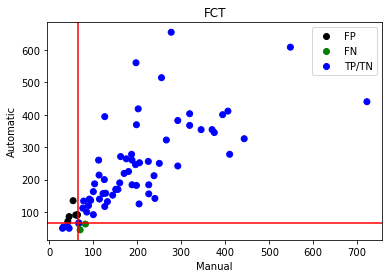

In [43]:
corr_plot(manual_fct, ai_fct_model3, 65, 'FCT')

Corr Lipid arc: [[1.         0.94085203]
 [0.94085203 1.        ]]


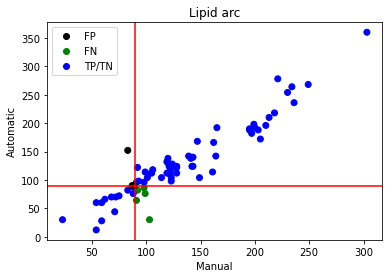

In [44]:
corr_plot(manual_arc, ai_arc_model3, 90, 'Lipid arc')

In [45]:
calculate_icc(ai_fct_model3, manual_fct)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.709084,5.874825,72,73,5.918496e-13,"[0.57, 0.81]"
1,ICC2,Single random raters,0.714165,6.692739,72,72,2.482220e-14,"[0.55, 0.82]"
2,ICC3,Single fixed raters,0.740015,6.692739,72,72,2.482220e-14,"[0.62, 0.83]"
3,ICC1k,Average raters absolute,0.829782,5.874825,72,73,5.918496e-13,"[0.73, 0.89]"
4,ICC2k,Average random raters,0.833251,6.692739,72,72,2.482220e-14,"[0.71, 0.9]"
5,ICC3k,Average fixed raters,0.850584,6.692739,72,72,2.482220e-14,"[0.76, 0.91]"


In [46]:
calculate_icc(ai_arc_model3, manual_arc)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.931890,28.364393,72,73,4.043117e-34,"[0.89, 0.96]"
1,ICC2,Single random raters,0.931882,28.266339,72,72,1.101359e-33,"[0.89, 0.96]"
2,ICC3,Single fixed raters,0.931662,28.266339,72,72,1.101359e-33,"[0.89, 0.96]"
3,ICC1k,Average raters absolute,0.964745,28.364393,72,73,4.043117e-34,"[0.94, 0.98]"
4,ICC2k,Average random raters,0.964740,28.266339,72,72,1.101359e-33,"[0.94, 0.98]"
5,ICC3k,Average fixed raters,0.964622,28.266339,72,72,1.101359e-33,"[0.94, 0.98]"


# Manual vs automatic measurements (on manual segs)

## Bland Altman using same manual segmentations

Found 0 FP and 0 FN. Total values are 76


(-400.0, 400.0)

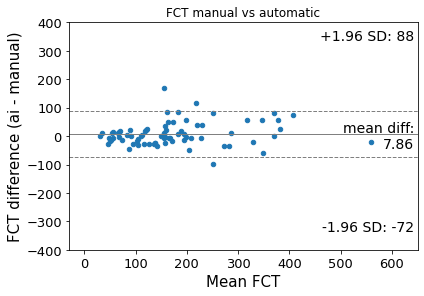

In [107]:
manual_fct, automatic_fct = get_data_filtered(measurements, 'FCT manual', 'FCT automatic')

fig, axes = plt.subplots()

sm.graphics.mean_diff_plot(automatic_fct, manual_fct, ax = axes)
plt.xlabel('Mean FCT')
plt.ylabel('FCT difference (ai - manual)')
plt.title('FCT manual vs automatic')
plt.xlim(-30, 650)
plt.ylim(-400, 400)

Found 0 FP and 0 FN. Total values are 76


(-75.0, 150.0)

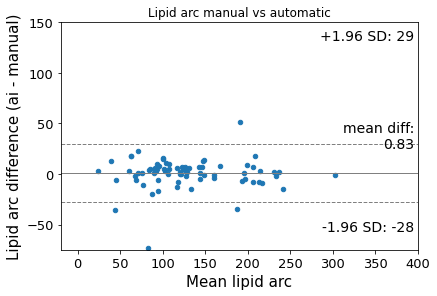

In [108]:
manual_arc, automatic_arc = get_data_filtered(measurements, 'Lipid arc manual', 'Lipid arc automatic')


fig, axes = plt.subplots()

sm.graphics.mean_diff_plot(automatic_arc, manual_arc, ax = axes)
plt.xlabel('Mean lipid arc')
plt.ylabel('Lipid arc difference (ai - manual)')
plt.title('Lipid arc manual vs automatic')
plt.xlim(-20, 400)
plt.ylim(-75, 150)


## Pearson and ICC 

Corr FCT: [[1.         0.94489705]
 [0.94489705 1.        ]]


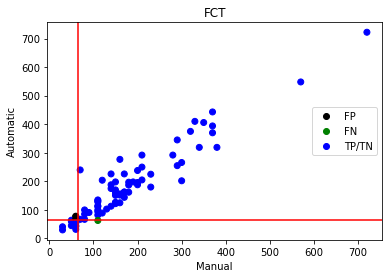

In [109]:
corr_plot(manual_fct, automatic_fct, 65, 'FCT')

Corr Lipid arc: [[1.         0.96704953]
 [0.96704953 1.        ]]


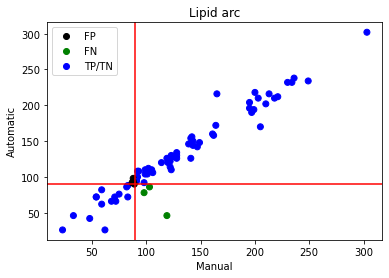

In [110]:
corr_plot(manual_arc, automatic_arc, 90, 'Lipid arc')

In [111]:
calculate_icc(automatic_fct, manual_fct)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.942673,33.88754,75,76,3.316828e-38,"[0.91, 0.96]"
1,ICC2,Single random raters,0.942710,34.67031,75,75,3.881077e-38,"[0.91, 0.96]"
2,ICC3,Single fixed raters,0.943931,34.67031,75,75,3.881077e-38,"[0.91, 0.96]"
3,ICC1k,Average raters absolute,0.970491,33.88754,75,76,3.316828e-38,"[0.95, 0.98]"
4,ICC2k,Average random raters,0.970510,34.67031,75,75,3.881077e-38,"[0.95, 0.98]"
5,ICC3k,Average fixed raters,0.971157,34.67031,75,75,3.881077e-38,"[0.95, 0.98]"


In [112]:
calculate_icc(automatic_arc, manual_arc)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.967365,60.283456,75,76,2.650079e-47,"[0.95, 0.98]"
1,ICC2,Single random raters,0.967359,59.684297,75,75,1.310311e-46,"[0.95, 0.98]"
2,ICC3,Single fixed raters,0.967043,59.684297,75,75,1.310311e-46,"[0.95, 0.98]"
3,ICC1k,Average raters absolute,0.983412,60.283456,75,76,2.650079e-47,"[0.97, 0.99]"
4,ICC2k,Average random raters,0.983409,59.684297,75,75,1.310311e-46,"[0.97, 0.99]"
5,ICC3k,Average fixed raters,0.983245,59.684297,75,75,1.310311e-46,"[0.97, 0.99]"
